In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import pearsonr, kendalltau
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(30)

# Data

### Import and merging
> since we have two datasets, we are considering merging them so we want to see if there are companies in one dataset and does not exist in the other

In [2]:
tech = pd.read_csv("layoffs_data.csv")
all_com = pd.read_csv("layoffs.csv")
print("Shape:")
print("tech " + str(tech.shape))
print("all_com " + str(all_com.shape))
print("Columns:")
print({"tech": list(tech.columns.values), "all_com": list(all_com.columns.values)})

Shape:
tech (3577, 12)
all_com (3568, 9)
Columns:
{'tech': ['Company', 'Location_HQ', 'Industry', 'Laid_Off_Count', 'Percentage', 'Date', 'Source', 'Funds_Raised', 'Stage', 'Date_Added', 'Country', 'List_of_Employees_Laid_Off'], 'all_com': ['company', 'location', 'industry', 'total_laid_off', 'percentage_laid_off', 'date', 'stage', 'country', 'funds_raised']}


In [3]:
extra = set(tech["Company"]) - set(all_com["company"])
print("Companies in tech but not in all_com:")
print(extra)

Companies in tech but not in all_com:
{'Pax8', 'True Anomaly', 'Heureka Group', 'Freenome'}


### Result:
> 1. The only additional columns in tech is Date_Added, Source and List_of_Employees_Laid_Off which are irrelevent to the question we are curious about. So We would just drop these columns and concatenate the two dataframe together
> 2. There are company exist exclusively in tech dataframe so we would just concatinate them and drop duplicates

### Clean dataframe for merging

In [4]:
all_com.columns = ["company","hq_location", "industry","laid_off_count","laid_off_percent","date","stage","country","fund"]
tech = tech[["Company","Location_HQ","Industry","Laid_Off_Count","Percentage","Date","Stage","Country","Funds_Raised"]]
#rename columns
tech.columns = ["company","hq_location", "industry","laid_off_count","laid_off_percent","date","stage","country","fund"]
tech["date"] = tech["date"].apply(lambda x: x.split("T")[0])
#merge
merged = pd.concat([all_com, tech], axis=0).drop_duplicates()
#change date to datetime object and sort by date
merged['date'] = pd.to_datetime(merged['date'])
merged = merged.sort_values('date')
#format the industry column
merged.loc[(merged["industry"] == "Unknown"), "industry"] = "Other"
#clean for unaligned info
merged = merged[~(((merged["laid_off_count"] != 0) & (merged["laid_off_percent"] == 0)) | ((merged["laid_off_count"] != 0) & (merged["laid_off_percent"] == 0))) ]
print(merged.shape)
merged.head()

(3583, 9)


company     hq_location        industry  laid_off_count  \
3567       EasyPost  Salt Lake City       Logistics            75.0   
3566  Tamara Mellon     Los Angeles          Retail            20.0   
3565    Panda Squad     SF Bay Area        Consumer             6.0   
3564   HopSkipDrive     Los Angeles  Transportation             8.0   
3561      Inspirato          Denver          Travel           130.0   

      laid_off_percent       date     stage        country  fund  
3567               NaN 2020-03-11  Series A  United States  12.0  
3566              0.40 2020-03-12  Series C  United States  90.0  
3565              0.75 2020-03-13      Seed  United States   1.0  
3564              0.10 2020-03-13   Unknown  United States  45.0  
3561              0.22 2020-03-16  Series C  United States  79.0

# EDA

## About the data

In [5]:
f'There are {merged.shape[0]} observations and {merged.shape[1]} columns in the merged dataframe'

'There are 3583 observations and 9 columns in the merged dataframe'

In [6]:
f'There are {len(np.unique(merged["company"]))} unique companies in the dataset'

'There are 2572 unique companies in the dataset'

In [7]:
f'There are {len(np.unique(merged.dropna(subset=["industry"])["industry"]))} unique industry in the dataset'

'There are 30 unique industry in the dataset'

#### Description of the columns and data type

1. company: Name of the company
2. hq_location: Location of company headquarters
3. industy: Industry of the company
4. laid_off_count: Number of employees laid off
5. laid_off_percent: Percentage of employees laid off
6. date: Year, Month, Date of the layoff
7. stage: Stage of funding
8. country: Country of the company
9. fund: Funds raised by the company (in Millions dollar)

#### Data type

1. company: categorical
2. hq_location: categorical
3. industy: categorical
4. laid_off_count: discrete
4. laid_off_percent: continuous
6. date: discete
6. stage: categorical
7. country: categorical
8. fund: continuous
10. year: discrete
11. month: discrete

## Missing values and imputation

In [8]:
np.sum(merged.isna())

company                0
hq_location            1
industry               1
laid_off_count      1240
laid_off_percent    1278
date                   0
stage                  7
country                0
fund                 389
dtype: int64

* For hq_location, since there are only 1 missing value, we conduct a research to fillin the null value.
* For industry, we would do the same since there are only one missing row.
* For laid_off_count, since this is our response variable, we would drop all null value to avoid introducing baised to the dataset.
* For laid_off_percent, since this is our response variable, we would drop all null value to avoid introducing baised to the dataset.
* For stage, we would impute by probability within the industry.
* For fund, we would impute by taking the mean of the fund of companies that are in the same stage since they are more likely to dependent to each other.

In [9]:
# drop all for laid_off_percent and laid_off_count
merged.dropna(subset=['laid_off_percent'], inplace=True)
merged.dropna(subset=['laid_off_count'], inplace=True)

# imputation for industry
merged.loc[merged["industry"].isna(),'industry'] = "Security"

#imputation for stage
stage_probabilities = merged.groupby('industry')['stage'].value_counts(normalize=True).unstack()
for index, row in merged[merged['stage'].isnull()].iterrows():
    industry = row['industry']
    probabilities = stage_probabilities.loc[industry].dropna()
    imputed_stage = np.random.choice(probabilities.index, p=probabilities.values)
    merged.at[index, 'stage'] = imputed_stage

#imputation for fund
stage_means = merged.groupby('stage')['fund'].mean()
for index, row in merged[merged['fund'].isnull()].iterrows():
    stage = row['stage']
    mean_fund = stage_means.loc[stage]
    merged.at[index, 'fund'] = mean_fund

In [10]:
f'There are {np.sum(np.sum(merged.isna()))} missing value in the dataframe'

'There are 0 missing value in the dataframe'

In [11]:
num_unique_companies = len(np.unique(merged["company"]))
num_unique_industries = len(np.unique(merged["industry"]))
unique_countries = len(np.unique(merged["country"]))
num_unique_stages = len(np.unique(merged["stage"]))
output_string = f'After imputation and cleaning, there are {num_unique_companies} unique companies from {num_unique_industries} different industries, and these companies are from {unique_countries} different countries and are in {num_unique_stages} different stages.'
print(output_string)

After imputation and cleaning, there are 1330 unique companies from 30 different industries, and these companies are from 45 different countries and are in 16 different stages.


## Feature engineering

Step1: Since company size is relevant to our analysis and the laid_off_count and laid_off_percent columns provide redundant information, we will calculate the company size using laid_off_count and laid_off_percent, then drop the laid_off_count column

In [12]:
merged["company_size"] = round(merged["laid_off_count"] / merged["laid_off_percent"], 0)
merged.drop(columns=["laid_off_count"], inplace=True)

Step2: We would divide the date column into year and month for accessing annual and seasonal trend

In [13]:
merged["year"] = merged["date"].dt.year
merged["month"] = merged["date"].dt.month

In [14]:
merged.head()

company  hq_location        industry  laid_off_percent       date  \
3566  Tamara Mellon  Los Angeles          Retail              0.40 2020-03-12   
3565    Panda Squad  SF Bay Area        Consumer              0.75 2020-03-13   
3564   HopSkipDrive  Los Angeles  Transportation              0.10 2020-03-13   
3561      Inspirato       Denver          Travel              0.22 2020-03-16   
3562       Help.com       Austin         Support              1.00 2020-03-16   

         stage        country  fund  company_size  year  month  
3566  Series C  United States  90.0          50.0  2020      3  
3565      Seed  United States   1.0           8.0  2020      3  
3564   Unknown  United States  45.0          80.0  2020      3  
3561  Series C  United States  79.0         591.0  2020      3  
3562      Seed  United States   6.0          16.0  2020      3

# EDA Plots

## Numerical cols

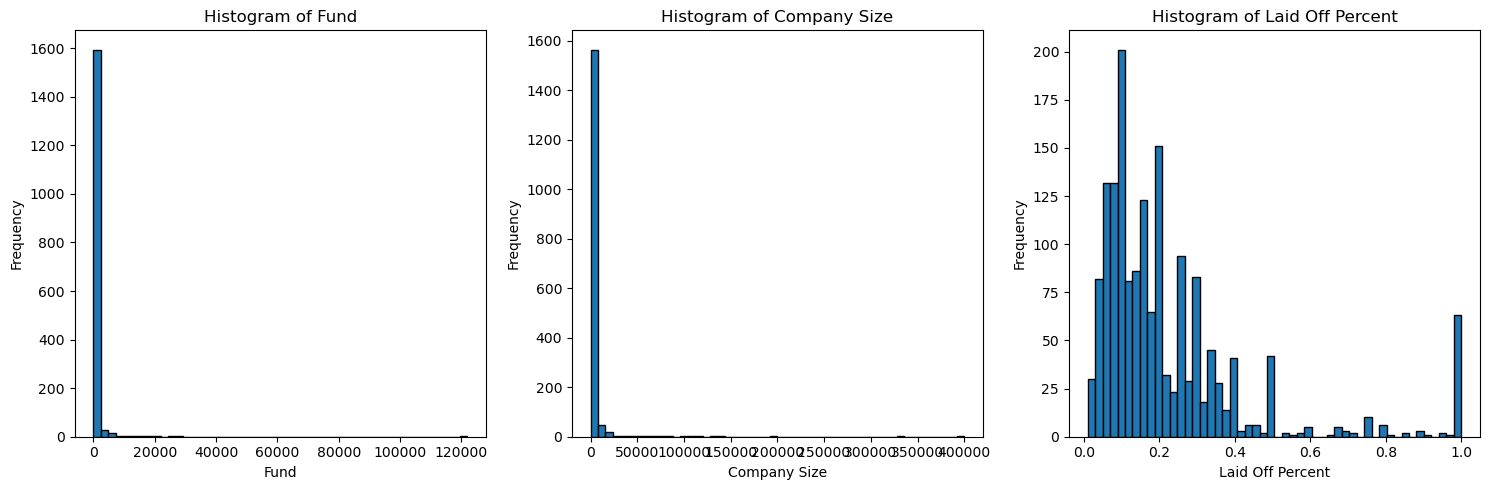

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(merged['fund'], bins=50, edgecolor='black')
plt.title('Histogram of Fund')
plt.xlabel('Fund')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(merged['company_size'], bins=50, edgecolor='black')
plt.title('Histogram of Company Size')
plt.xlabel('Company Size')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(merged['laid_off_percent'], bins=50, edgecolor='black')
plt.title('Histogram of Laid Off Percent')
plt.xlabel('Laid Off Percent')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [16]:
top_size = np.unique(merged.sort_values("company_size").tail(5)["company"])
top_fund = np.unique(merged.sort_values("fund").tail(5)["company"])
top_laid_off = np.unique(merged.sort_values("laid_off_percent").tail(5)["company"])
print(f"The top 5 companies that have the largest size are {top_size}")
print(f"The top 5 companies that have the highest amount of fund are {top_fund}")
print(f"The top 5 companies that have the highest laid_off_percent are {top_laid_off}")

The top 5 companies that have the largest size are ['Amazon' 'Google' 'IBM' 'Microsoft']
The top 5 companies that have the highest amount of fund are ['Meta' 'Netflix' 'Uber' 'Xerox']
The top 5 companies that have the highest laid_off_percent are ['Ahead' 'Deliv' 'Drizly' 'Jump' 'Playdots']


Unpon researching, the company size for Google, Amazon, IBM and Microsoft does not align with the actual value and may be due to a mistake. However, since they are all top leading company in the field that worth investigating, we would tried to replace them with values we found from reliable source.

For fund values, they are reasonable so we won't remove any large values.

In [17]:
merged.loc[merged["company"] == "Amazon", "company_size"] = 1521000
merged.loc[merged["company"] == "Google", "company_size"] = 182502
merged.loc[merged["company"] == "Microsoft", "company_size"] = 221000
merged.loc[merged["company"] == "IBM", "company_size"] = 282200

We would ignored companies that are aboved 97 percentile for fund and company size to get a better visualization

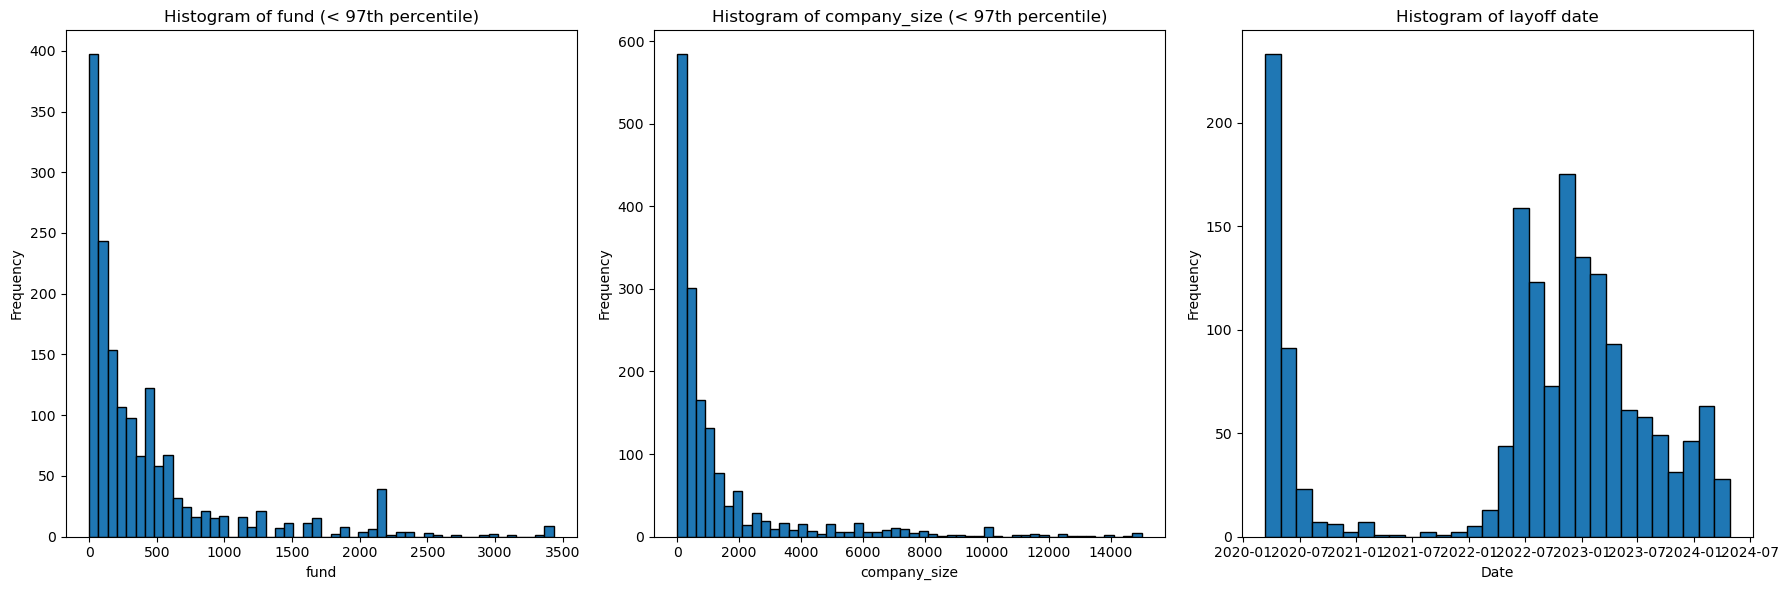

In [18]:
percentile_company_size = np.percentile(merged["company_size"], 97)
percentile_fund = np.percentile(merged["fund"], 97)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.hist(merged[merged["fund"] <= percentile_fund]["fund"], bins=50, edgecolor='black')
plt.title("Histogram of fund (< 97th percentile)")
plt.xlabel("fund")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(merged[merged["company_size"] <= percentile_company_size]["company_size"], bins=50, edgecolor='black')
plt.title("Histogram of company_size (< 97th percentile)")
plt.xlabel("company_size")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(merged["date"], bins=30, edgecolor='black')
plt.xlabel('Date')
plt.title("Histogram of layoff date")
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap of company_size, fund, and laid_off_percent')

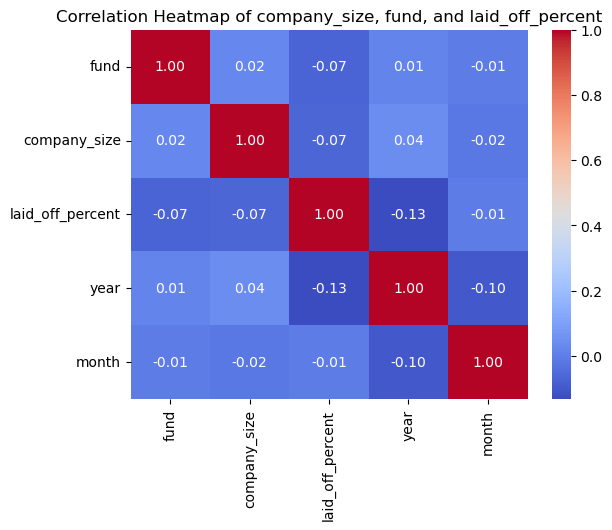

In [19]:
sns.heatmap(merged[["fund", "company_size", "laid_off_percent","year","month"]].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of company_size, fund, and laid_off_percent')

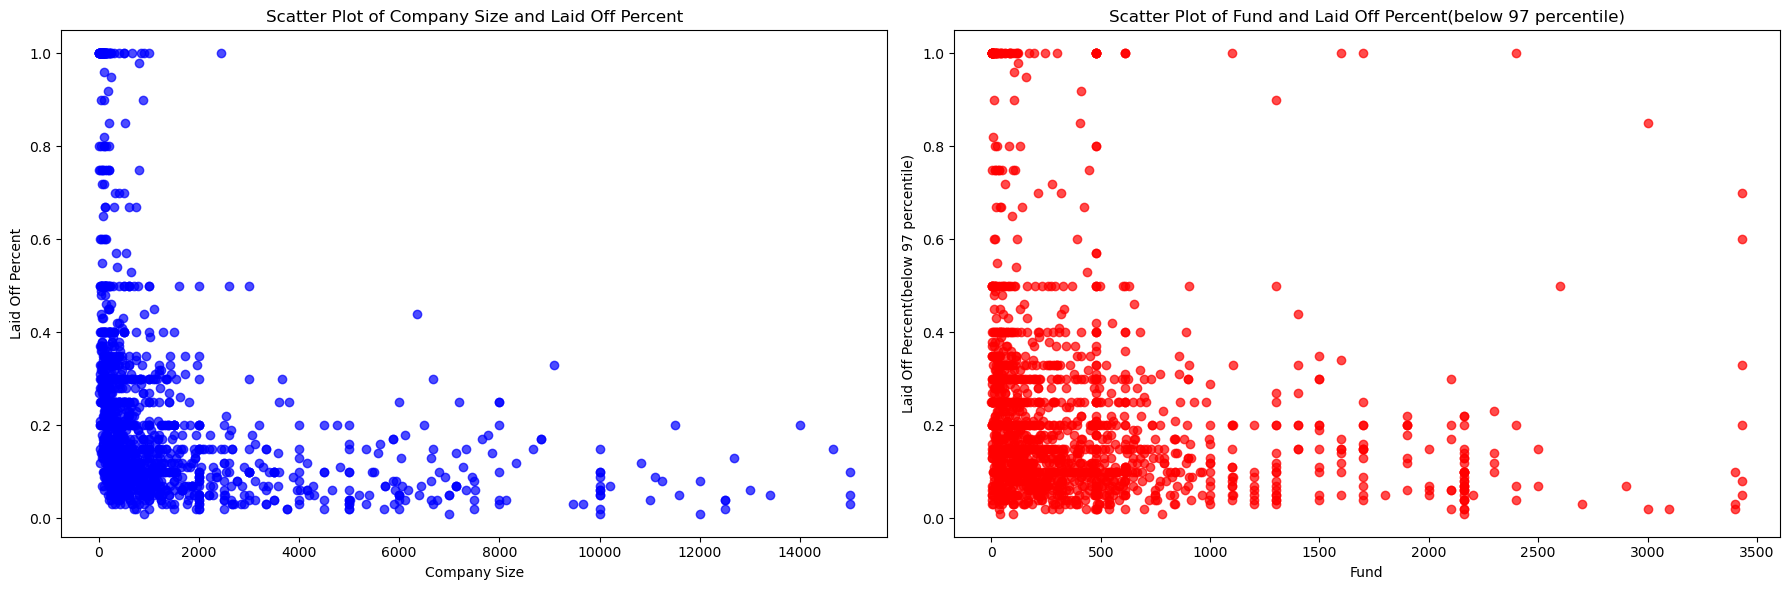

In [20]:
filtered_data = merged[(merged["company_size"] <= percentile_company_size) & (merged["fund"] <= percentile_fund)]
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(filtered_data['company_size'], filtered_data['laid_off_percent'], c='b', alpha=0.7)
plt.xlabel('Company Size')
plt.ylabel('Laid Off Percent')
plt.title('Scatter Plot of Company Size and Laid Off Percent')
plt.subplot(1, 2, 2)
plt.scatter(filtered_data['fund'], filtered_data['laid_off_percent'], c='r', alpha=0.7)
plt.xlabel('Fund')
plt.ylabel('Laid Off Percent(below 97 percentile)')
plt.title('Scatter Plot of Fund and Laid Off Percent(below 97 percentile)')

plt.tight_layout()
plt.show()

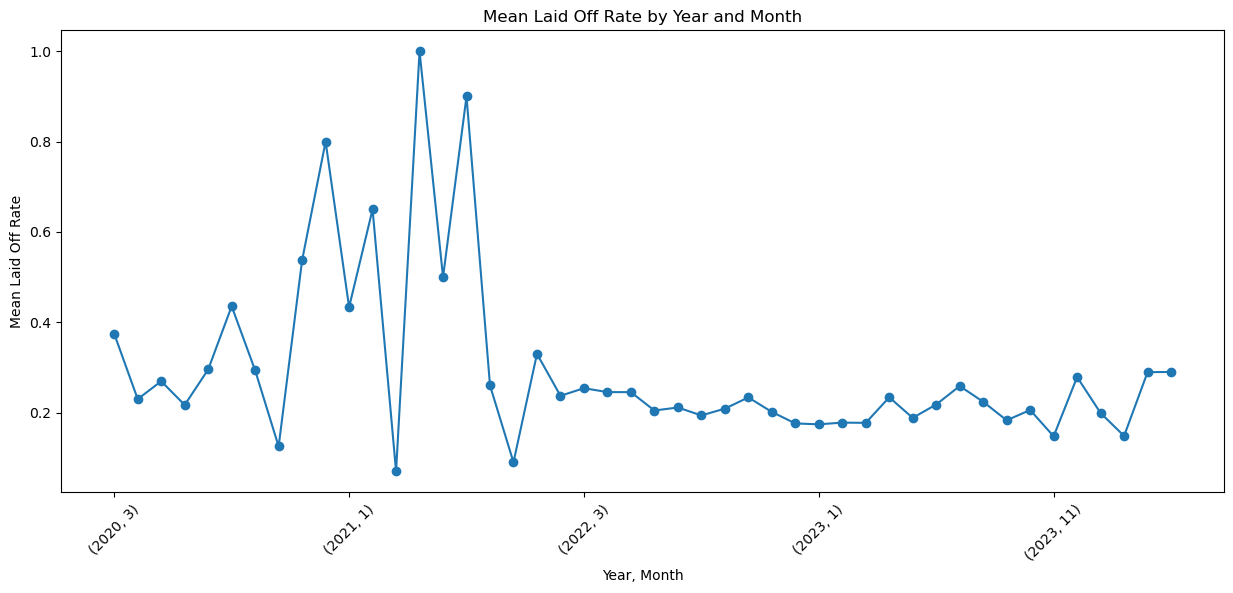

In [21]:
mean_laid_off_rate_year_month = merged.groupby(['year', 'month'])['laid_off_percent'].mean()
plt.figure(figsize=(15, 6))
mean_laid_off_rate_year_month.plot(marker='o')
plt.xlabel('Year, Month')
plt.ylabel('Mean Laid Off Rate')
plt.title('Mean Laid Off Rate by Year and Month')
plt.xticks(rotation=45)  
plt.show()

In [22]:
fig = px.choropleth(
    merged,
    locations="country",
    locationmode="country names",
    color="laid_off_percent",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Layoff Rate by Country"
)
# Show the map
fig.show()

## Categorical cols

In [23]:
industry_proportions = (merged.groupby("industry").count()["company"] / merged.shape[0]).sort_values(ascending=False)
stage_proportions = (merged.groupby("stage").count()["country"] / merged.shape[0]).sort_values(ascending=False)
hq_location_proportions = (merged.groupby("hq_location").count()["company"] / merged.shape[0]).sort_values(ascending=False).head(30)
country_proportions = (merged.groupby("country").count()["company"] / merged.shape[0]).sort_values(ascending=False)

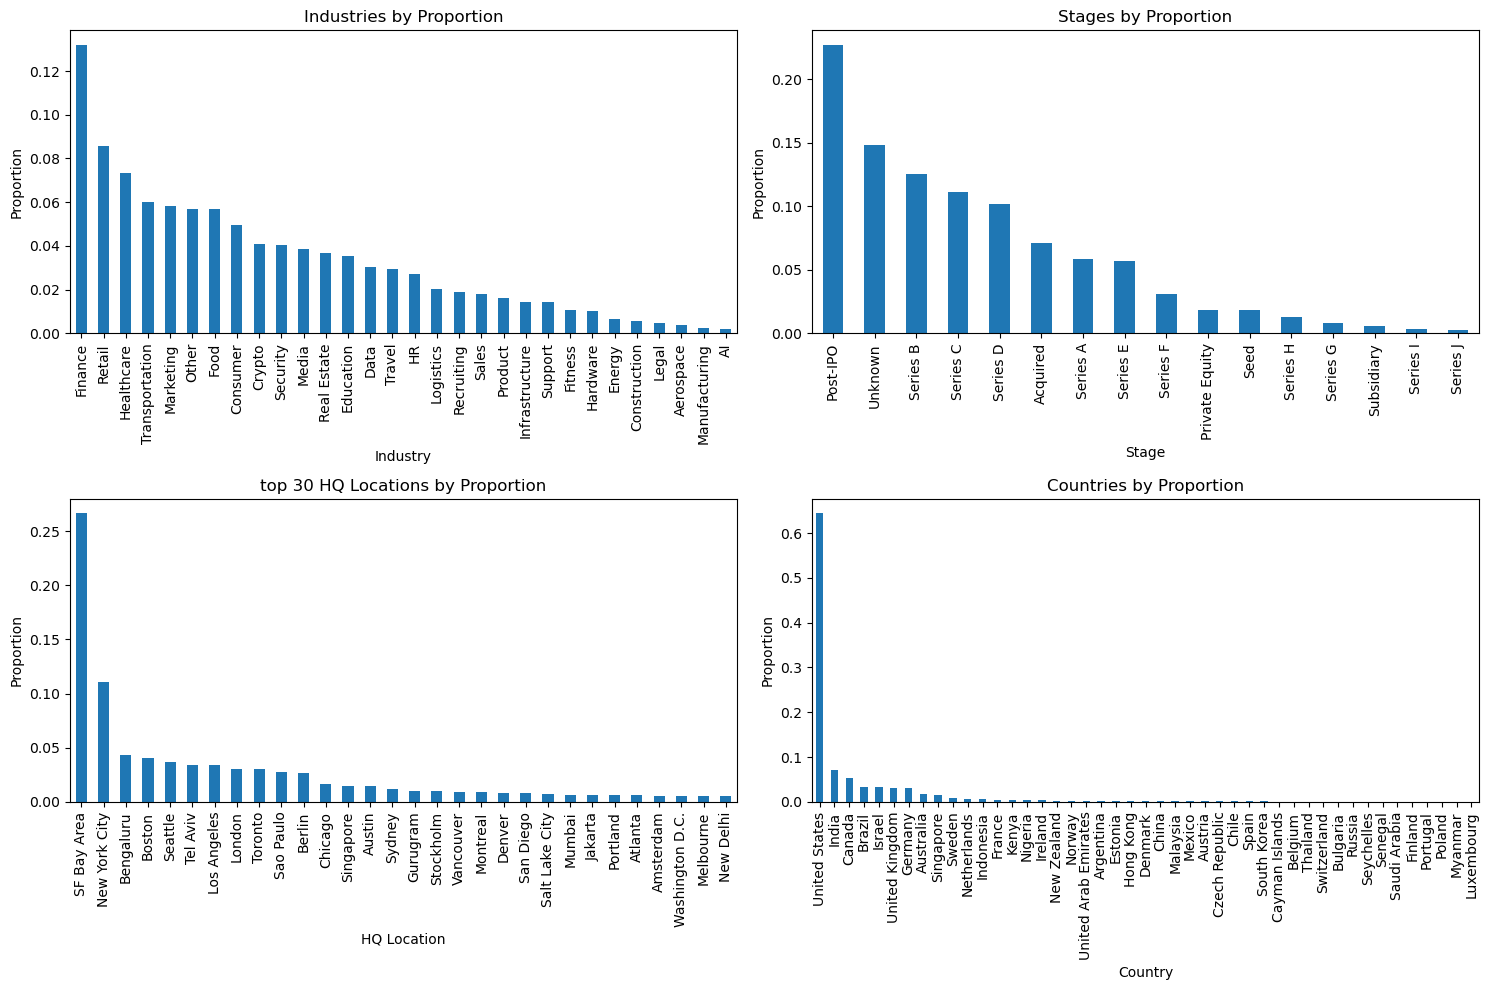

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
industry_proportions.plot(kind='bar', ax=axs[0, 0])
axs[0, 0].set_title('Industries by Proportion')
axs[0, 0].set_xlabel('Industry')
axs[0, 0].set_ylabel('Proportion')

stage_proportions.plot(kind='bar', ax=axs[0, 1])
axs[0, 1].set_title('Stages by Proportion')
axs[0, 1].set_xlabel('Stage')
axs[0, 1].set_ylabel('Proportion')

hq_location_proportions.plot(kind='bar', ax=axs[1, 0])
axs[1, 0].set_title('top 30 HQ Locations by Proportion')
axs[1, 0].set_xlabel('HQ Location')
axs[1, 0].set_ylabel('Proportion')

country_proportions.plot(kind='bar', ax=axs[1, 1])
axs[1, 1].set_title('Countries by Proportion')
axs[1, 1].set_xlabel('Country')
axs[1, 1].set_ylabel('Proportion')

plt.tight_layout()
plt.show()

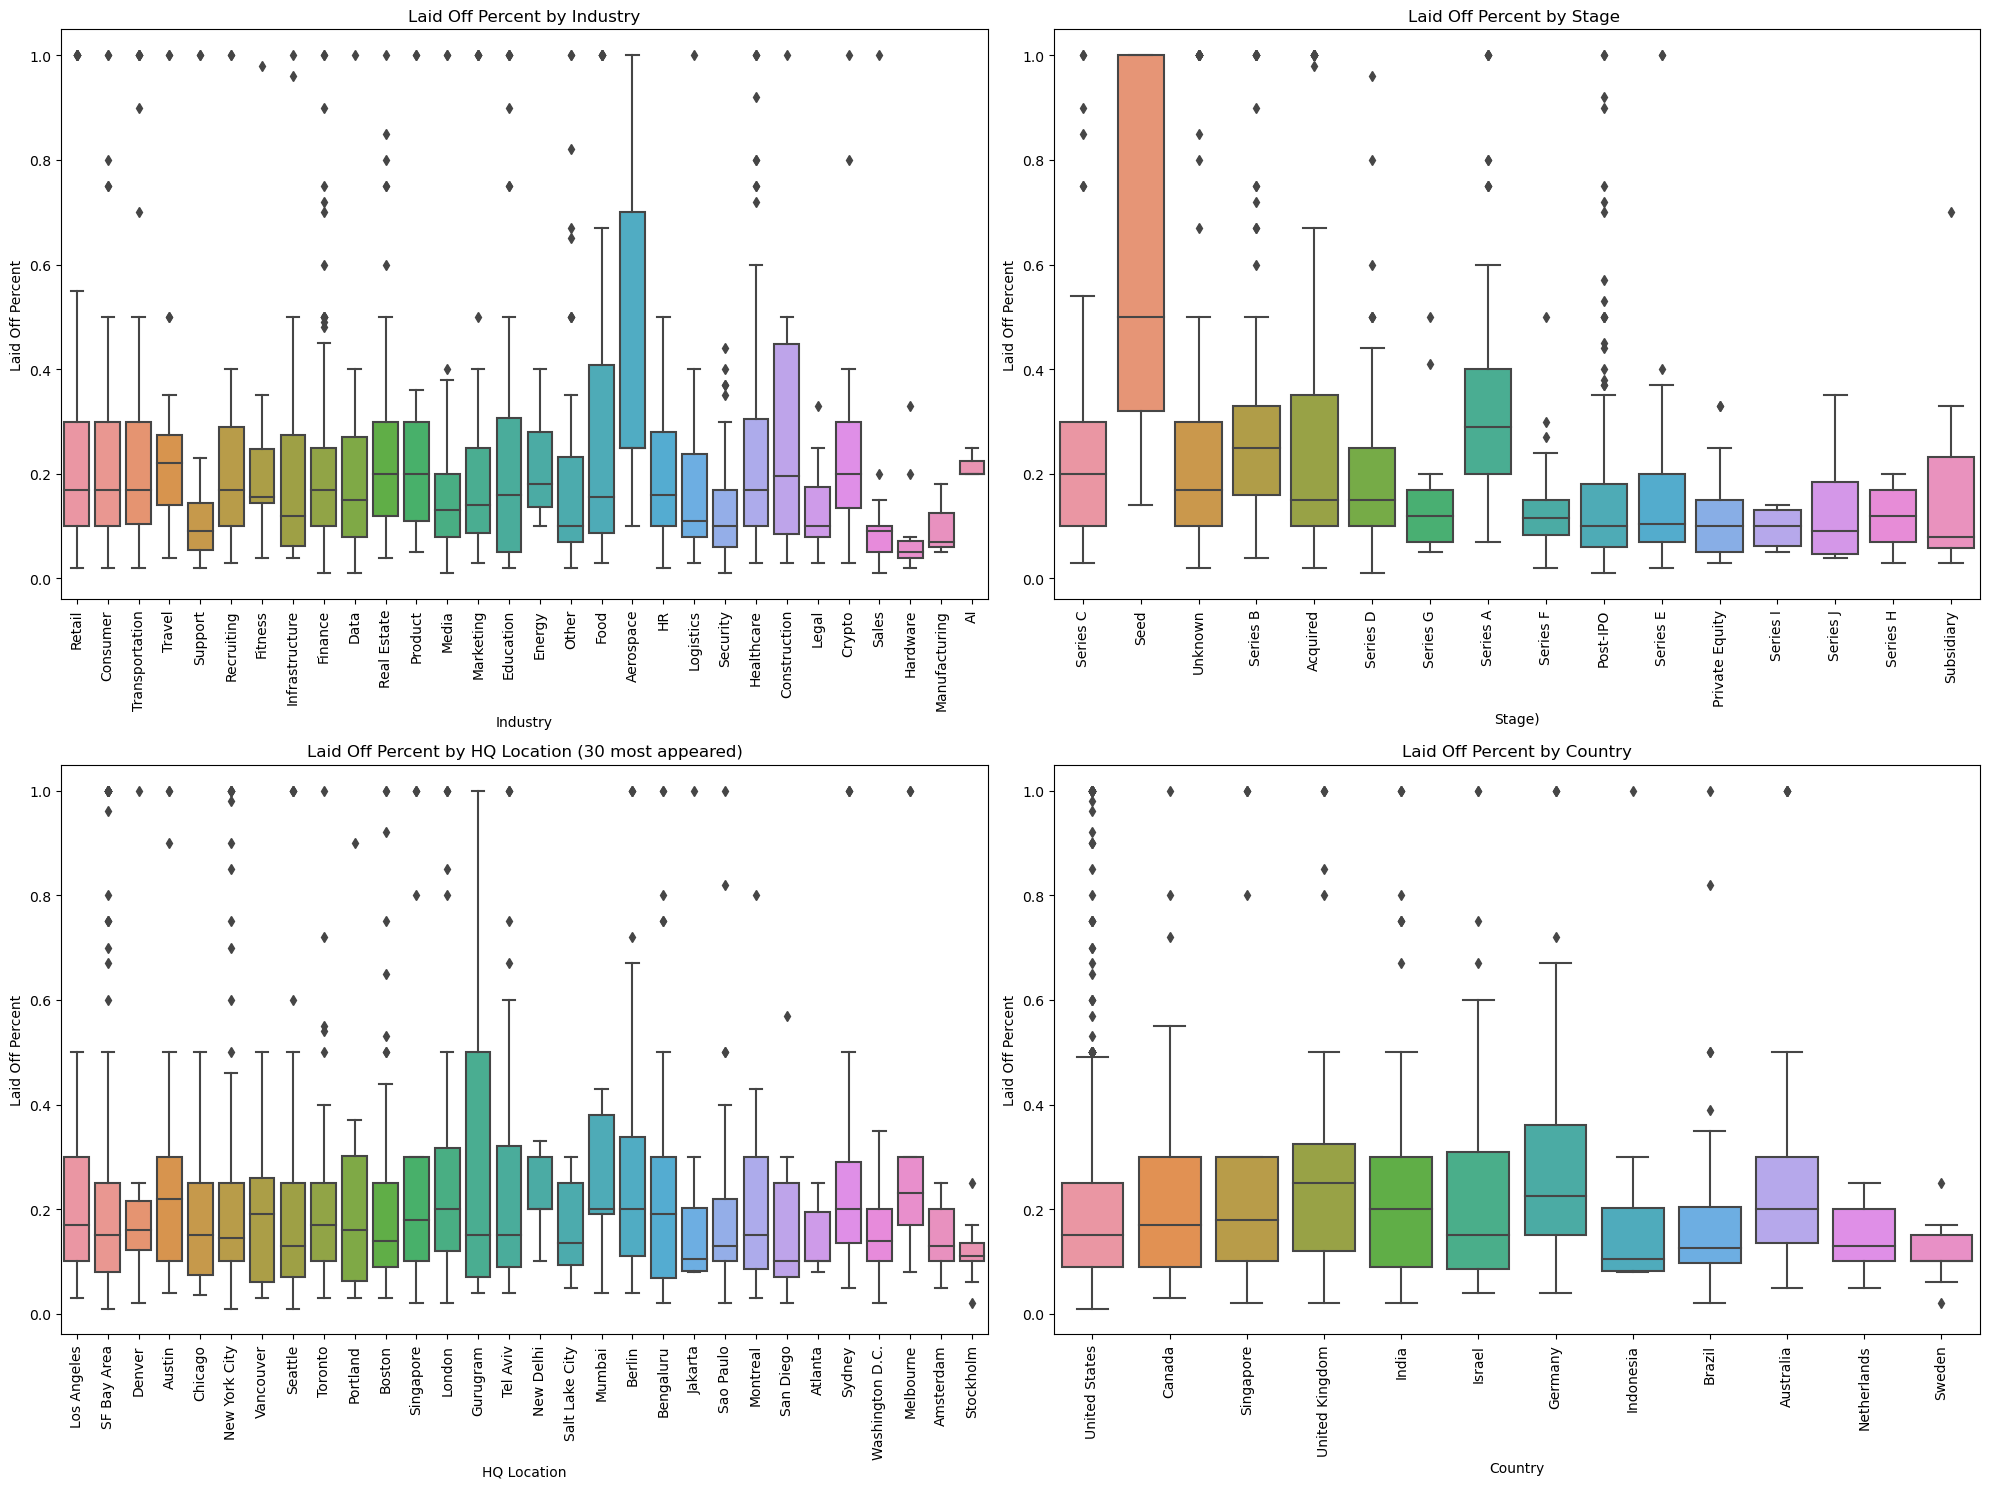

In [25]:
filtered_merged = merged[(merged['industry'].isin(industry_proportions.index)) &
                          (merged['stage'].isin(stage_proportions.index)) &
                          (merged['hq_location'].isin(hq_location_proportions.index)) &
                          (merged['country'].isin(country_proportions.index))]

fig, axs = plt.subplots(2, 2, figsize=(20, 15))

sns.boxplot(x='industry', y='laid_off_percent', data=filtered_merged, ax=axs[0, 0])
axs[0, 0].set_title('Laid Off Percent by Industry')
axs[0, 0].set_xlabel('Industry')
axs[0, 0].set_ylabel('Laid Off Percent')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=90)

sns.boxplot(x='stage', y='laid_off_percent', data=filtered_merged, ax=axs[0, 1])
axs[0, 1].set_title('Laid Off Percent by Stage ')
axs[0, 1].set_xlabel('Stage)')
axs[0, 1].set_ylabel('Laid Off Percent')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=90)

sns.boxplot(x='hq_location', y='laid_off_percent', data=filtered_merged, ax=axs[1, 0])
axs[1, 0].set_title('Laid Off Percent by HQ Location (30 most appeared)')
axs[1, 0].set_xlabel('HQ Location')
axs[1, 0].set_ylabel('Laid Off Percent')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=90)

sns.boxplot(x='country', y='laid_off_percent', data=filtered_merged, ax=axs[1, 1])
axs[1, 1].set_title('Laid Off Percent by Country')
axs[1, 1].set_xlabel('Country')
axs[1, 1].set_ylabel('Laid Off Percent')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

# Analysis

### Chi-square test

Chi-Squared value: 2272.354875289291
P-value: 0.009598209710506208
Degrees of freedom: 2117
Expected frequencies:
[[1.26582278e-02 1.80831826e-03 3.97830018e-02 ... 1.80831826e-03
  1.80831826e-03 1.13924051e-01]
 [2.53164557e-02 3.61663653e-03 7.95660036e-02 ... 3.61663653e-03
  3.61663653e-03 2.27848101e-01]
 [3.79746835e-02 5.42495479e-03 1.19349005e-01 ... 5.42495479e-03
  5.42495479e-03 3.41772152e-01]
 ...
 [1.01265823e-01 1.44665461e-02 3.18264014e-01 ... 1.44665461e-02
  1.44665461e-02 9.11392405e-01]
 [4.21940928e-01 6.02772755e-02 1.32610006e+00 ... 6.02772755e-02
  6.02772755e-02 3.79746835e+00]
 [2.06751055e-01 2.95358650e-02 6.49789030e-01 ... 2.95358650e-02
  2.95358650e-02 1.86075949e+00]]


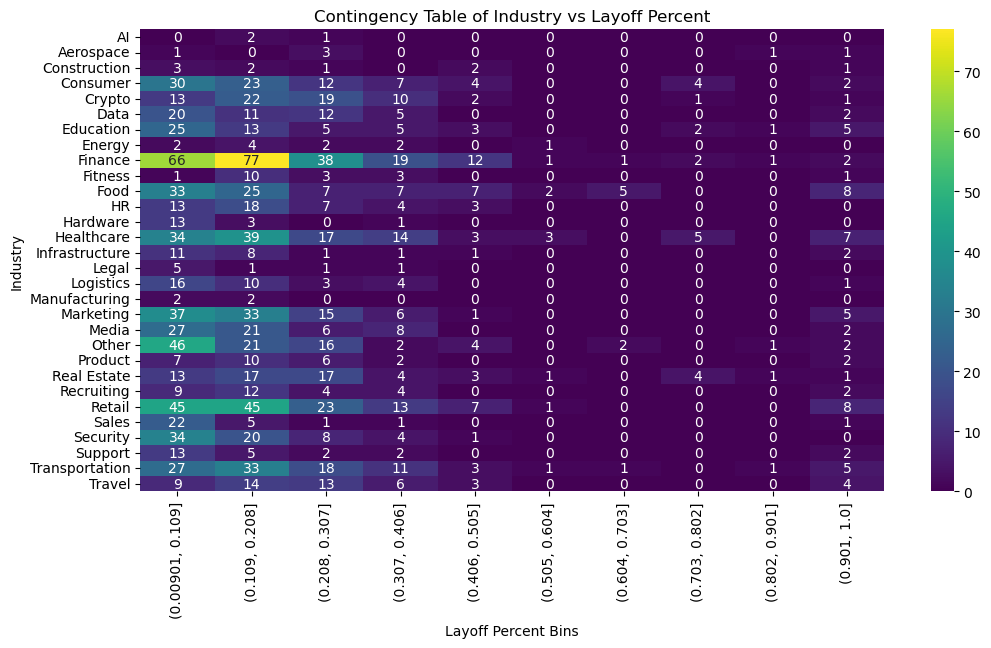

In [26]:
contingency_table = pd.crosstab(merged['industry'], merged['laid_off_percent'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
contingency_table = pd.crosstab(merged['industry'], pd.cut(merged['laid_off_percent'], bins=10))
plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='viridis')
plt.title('Contingency Table of Industry vs Layoff Percent')
plt.xlabel('Layoff Percent Bins')
plt.ylabel('Industry')
plt.show()

**Conclusion**
>The chi-squared value represents the test statistic that measures how much the observed frequencies deviate from the expected frequencies under the null hypothesis. In this case, the chi-squared value is quite large, which suggests a significant deviation. A p-value of 0.015617 indicates that there is a 1.5617% chance of obtaining a chi-squared value as extreme as the observed one under the null hypothesis. Since 0.015617 < 0.05, we reject the null hypothesis at the 5% significance level, meaning there is evidence to suggest a statistically significant association between the industry and the layoff rates. The heatmap visualizes the relationship between industries and different ranges of layoff percentages. It highlights patterns and clusters within the data, indicating where certain industries experience higher or lower layoff rates.


### Two-Sample t-test: Tech (AI, Crypo, Data) vs. Other Industries

In [27]:
tech_industries = ['AI', 'Crypto', 'Data']
tech_industry_layoffs = merged[merged['industry'].isin(tech_industries)]['laid_off_percent']
other_industries_layoffs = merged[~merged['industry'].isin(tech_industries)]['laid_off_percent']
mean_tech_industry_layoffs = tech_industry_layoffs.mean()
mean_other_industries_layoffs = other_industries_layoffs.mean()

t_stat, p_value = ttest_ind(tech_industry_layoffs, other_industries_layoffs, equal_var=False)

print(f"Mean Layoff Percentage (Selected Industries): {mean_tech_industry_layoffs}")
print(f"Mean Layoff Percentage (Other Industries): {mean_other_industries_layoffs}")
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")
if p_value < 0.05:
    print("There is a statistically significant difference in layoff percentages between the selected industries and the other industries.")
else:
    print("There is no statistically significant difference in layoff percentages between the selected industries and the other industries.")


Mean Layoff Percentage (Selected Industries): 0.22289256198347107
Mean Layoff Percentage (Other Industries): 0.22171488946684006
T-Statistic: 0.07105456097748288
P-Value: 0.94344816366609
There is no statistically significant difference in layoff percentages between the selected industries and the other industries.


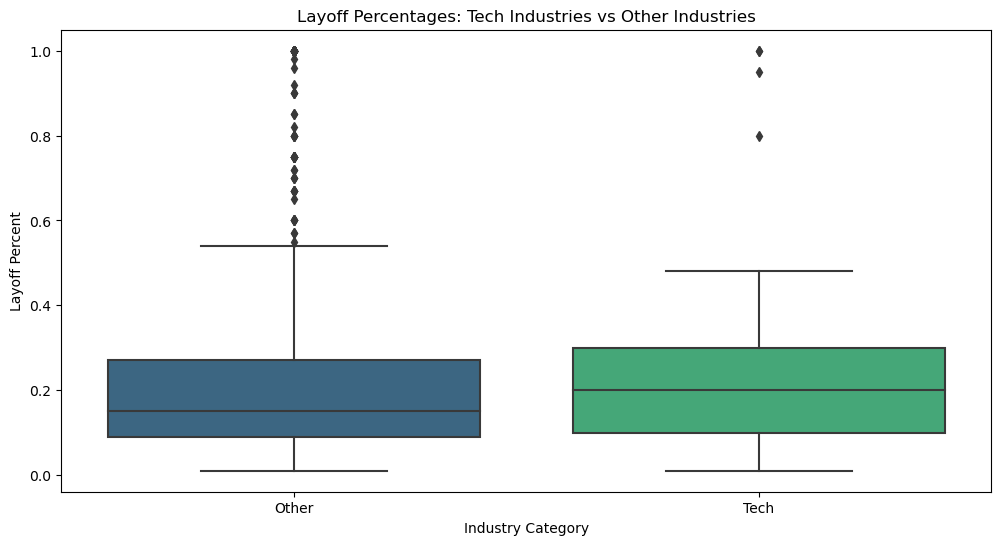

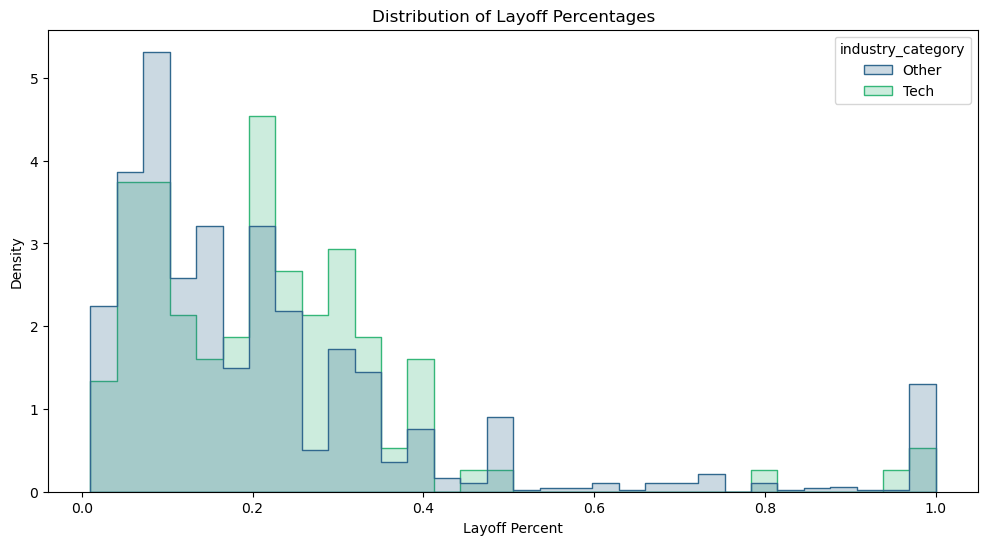

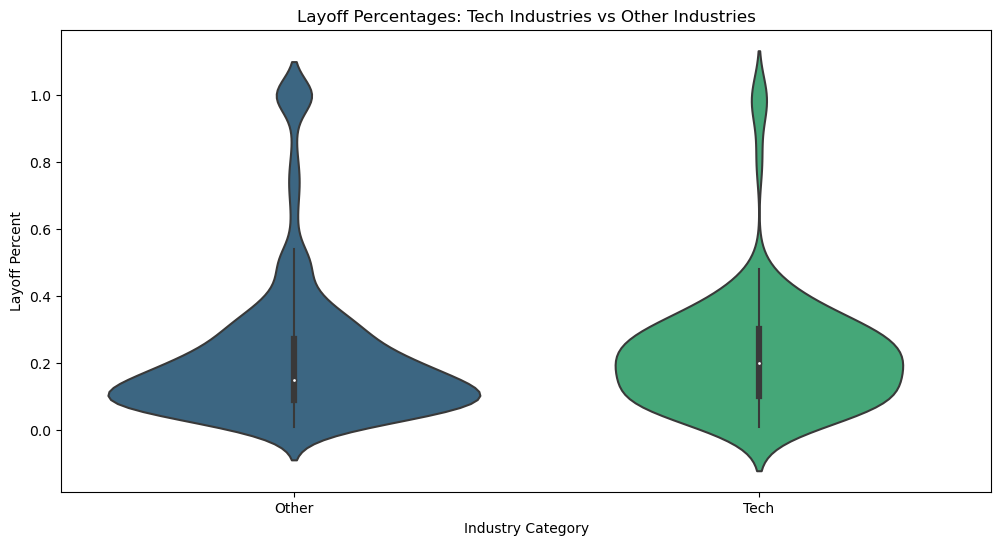

In [28]:
# categorize industries
merged['industry_category'] = merged['industry'].apply(lambda x: 'Tech' if x in tech_industries else 'Other')

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='industry_category', y='laid_off_percent', data=merged, palette='viridis')
plt.title('Layoff Percentages: Tech Industries vs Other Industries')
plt.xlabel('Industry Category')
plt.ylabel('Layoff Percent')
plt.show()

# Histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=merged, x='laid_off_percent', hue='industry_category', element='step', stat='density', common_norm=False, palette='viridis')
plt.title('Distribution of Layoff Percentages')
plt.xlabel('Layoff Percent')
plt.ylabel('Density')
plt.show()

# Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='industry_category', y='laid_off_percent', data=merged, palette='viridis', split=True)
plt.title('Layoff Percentages: Tech Industries vs Other Industries')
plt.xlabel('Industry Category')
plt.ylabel('Layoff Percent')
plt.show()

## Test for assocaition for Numirical data
> pearson correlation for linear association and kendall for monotonic association

In [29]:
all_company = merged.drop(columns = ["company", "date","industry_category"])

In [30]:
for col in ["fund", "company_size", "year", "month"]:
    data = all_company.dropna(subset=[col, 'laid_off_percent'])
    # Pearson correlation for linear association
    pearson_corr, pearson_p_value = pearsonr(data[col], data['laid_off_percent'])
    print(f"Pearson correlation for {col}: {pearson_corr}, p-value: {pearson_p_value}")

Pearson correlation for fund: -0.06700619026206563, p-value: 0.006329034852190625
Pearson correlation for company_size: -0.06584026119144991, p-value: 0.007304840758706599
Pearson correlation for year: -0.1328589788882808, p-value: 5.589137177546483e-08
Pearson correlation for month: -0.008008629685689956, p-value: 0.7444565511008393


**Conclusion**
1. for fund, there is week negative linear association
1. for company_size, it has weak negative association with the laid_off_percent
2. for year, there exist strong negative linear association
3. for month, both correlations suggest no significant association between "month" and "laid_off_percent"

**"fund", "company_size", and "year" are likely to be related to the "laid_off_percent" based on their significant correlations, while "month" does not appear to be associated with "laid_off_percent" in this analysis**


## Kolmogorov-Smirnov test for Categorical
> We use Bootstrap approach for all categorical data without making assumption of the underlying distribution

In [31]:
def ks_statistic(groups):
    J = len(groups)
    sup_values = []
    combined_sample = np.concatenate(groups)
    for j in range(J):
        F_j = np.searchsorted(groups[j], combined_sample, side='right') / len(groups[j])
        F_combined = np.searchsorted(combined_sample, combined_sample, side='right') / len(combined_sample)
        sup = np.max(np.abs(F_j - F_combined))
        sup_values.append(sup)
    D = np.sum(sup_values)
    return D

def bootstrap_p_value(groups, n_bootstraps=1000):
    observed_ks = ks_statistic(groups)
    N = len(np.concatenate(groups))
    B = n_bootstraps
    count = 0
    for _ in range(B):
        bootstrap_sample = np.random.choice(np.concatenate(groups), size=N, replace=True)
        bootstrap_groups = [bootstrap_sample[:len(group)] for group in groups]
        bootstrap_ks = ks_statistic(bootstrap_groups)
        if bootstrap_ks >= observed_ks:
            count += 1
    p_value = (count + 1) / (B + 1)
    return p_value

for col in ['hq_location', 'industry', 'stage', 'country']:
    groups = [all_company[all_company[col] == val]['laid_off_percent'].values for val in all_company[col].unique()]
    p_value = bootstrap_p_value(groups)
    print(f"Bootstrap p-value for {col}: {p_value}")

Bootstrap p-value for hq_location: 0.04595404595404595
Bootstrap p-value for industry: 0.04595404595404595
Bootstrap p-value for stage: 0.01098901098901099
Bootstrap p-value for country: 0.6033966033966034


Using a significance level of 0.05, we would conclude that 
1. there is a statistically significant difference in the "laid-off rate" across different categories of "hq_location" and "industry" and "stage"
2. there is no statistically significant difference in the "laid-off rate" across different countries

**"hq_location", "industry", and "stage" are likely to be good indicators of the "laid-off rate"e "month" does not appear to be associated with "laid_off_percent" in this analysis**

**Conclusion: "country" and "month" is not a good predictor for the laid off percent**

# Linear model

In [32]:
#with all covariates
formula = "laid_off_percent ~ " + " + ".join(all_company.columns.drop(["laid_off_percent"]))
full_model = smf.ols(formula, data = all_company).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:       laid_off_percent   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     2.446
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           4.94e-22
Time:                        16:59:58   Log-Likelihood:                 468.00
No. Observations:                1659   AIC:                            -512.0
Df Residuals:                    1447   BIC:                             635.8
Df Model:                         211                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [33]:
#with covariates found in the test
hypothsis_formula = "laid_off_percent ~ " + " + ".join(all_company.columns.drop(["laid_off_percent","country","month"]))
hypothsis_model = smf.ols(formula, data = all_company).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:       laid_off_percent   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     2.446
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           4.94e-22
Time:                        16:59:58   Log-Likelihood:                 468.00
No. Observations:                1659   AIC:                            -512.0
Df Residuals:                    1447   BIC:                             635.8
Df Model:                         211                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

The two have the same R-square and F statistic, which suggest that the conclusion we made in the previous section is valid. Adding them does not improved the model performance. However, this is just a rough test, we would dive into more in latter part.

## Check for assumption

### Normality

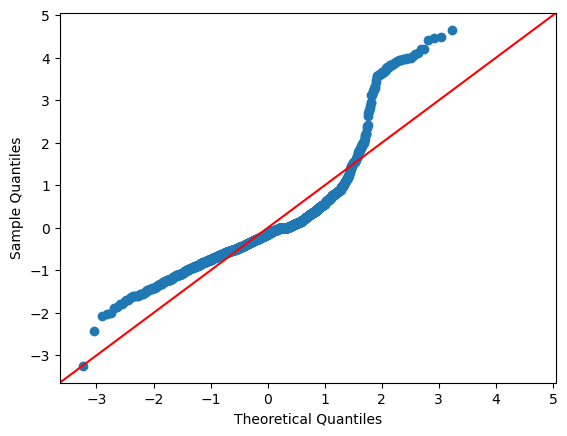

ShapiroResult(statistic=0.8257693648338318, pvalue=3.7709754428090136e-39)


In [34]:
def standardize(x):
    return (x - x.mean()) / x.std()
res = standardize(full_model.resid)
sm.qqplot(res, line = "45")
plt.show()
print(stats.shapiro(full_model.resid))

**Conclusion: normality assumption is violated**
> we can loged the response variable to fix it 

In [35]:
#log the response variable
all_company["laid_off_percent"] = np.log(all_company["laid_off_percent"])
#refit for both models
formula = "laid_off_percent ~ " + " + ".join(all_company.columns.drop(["laid_off_percent"]))
full_model = smf.ols(formula, data = all_company).fit()
print(full_model.summary())

hypothsis_formula = "laid_off_percent ~ " + " + ".join(all_company.columns.drop(["laid_off_percent","country","month"]))
hypothsis_model = smf.ols(formula, data = all_company).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:       laid_off_percent   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     3.111
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           5.33e-36
Time:                        16:59:59   Log-Likelihood:                -1776.9
No. Observations:                1659   AIC:                             3978.
Df Residuals:                    1447   BIC:                             5126.
Df Model:                         211                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Now we check for normality assumption again

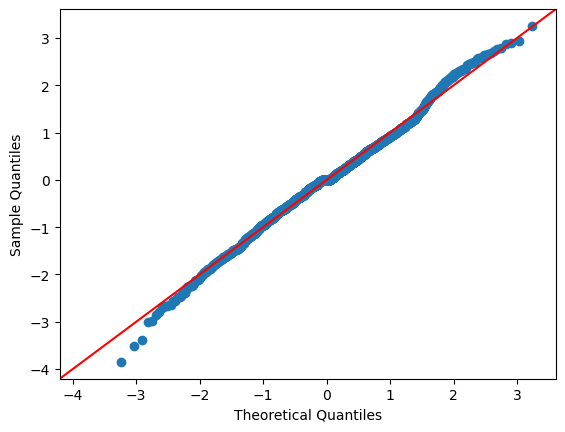

In [36]:
def standardize(x):
    return (x - x.mean()) / x.std()
res = standardize(full_model.resid)
sm.qqplot(res, line = "45")
plt.show()

**Assumption met**

### Independence of the residual

Text(0, 0.5, 'residual(stanarlized)')

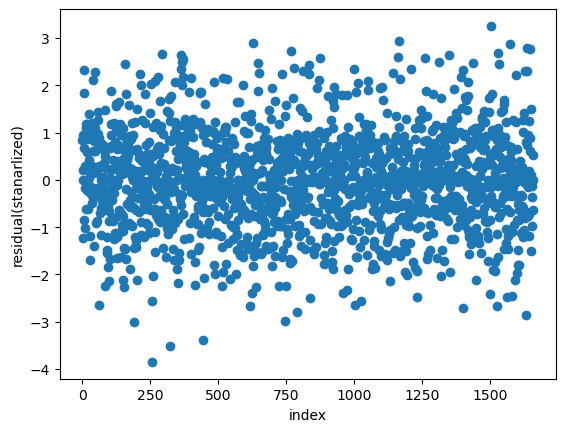

In [37]:
plt.scatter(range(len(res)), res)
plt.xlabel("index")
plt.ylabel("residual(stanarlized)")

**Conclusion: Since we cannot observed a clear pattern in the plot, the independent of the residual assumption is not violated.**

### Heterosecdasity

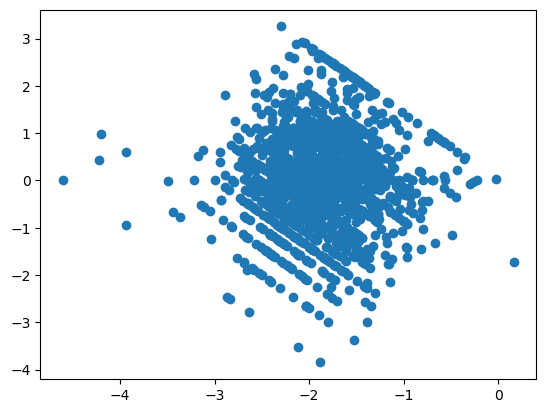

In [38]:
predicted = full_model.fittedvalues
plt.scatter(predicted, res)

**Conclusion: From the graph, we can observed a Fan-shaped Pattern which indicate heteroscedasticity in the residual. The assumption is violated.**

### Linearity

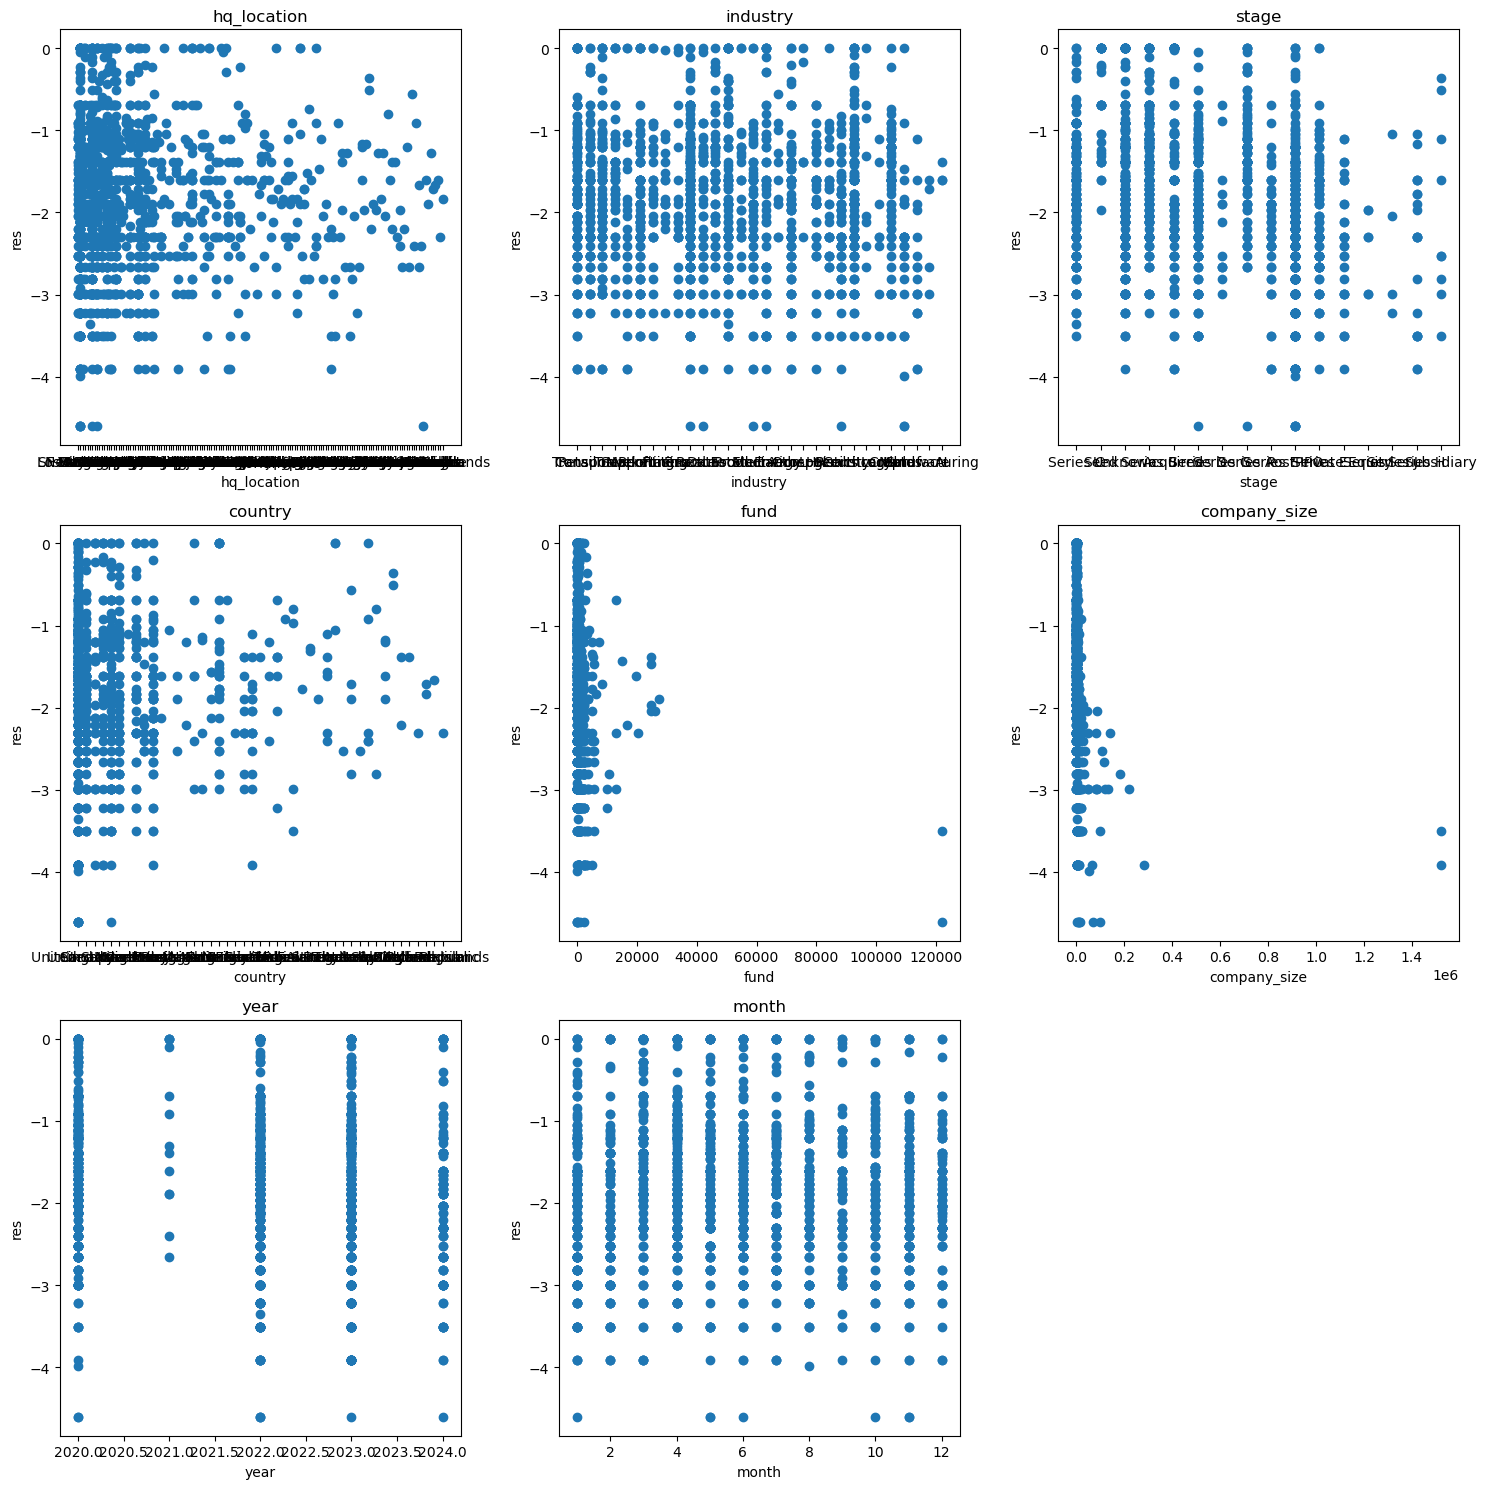

In [39]:
without_na = all_company.dropna()
n_cols = 3
n_rows = int(np.ceil(len(without_na.columns) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axs = axs.flatten()
for i, col in enumerate(without_na.drop(columns="laid_off_percent").columns):
    axs[i].scatter(without_na[col], without_na['laid_off_percent'])
    axs[i].set_title(col)
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('res')
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


### Zoom in for funds and company_size

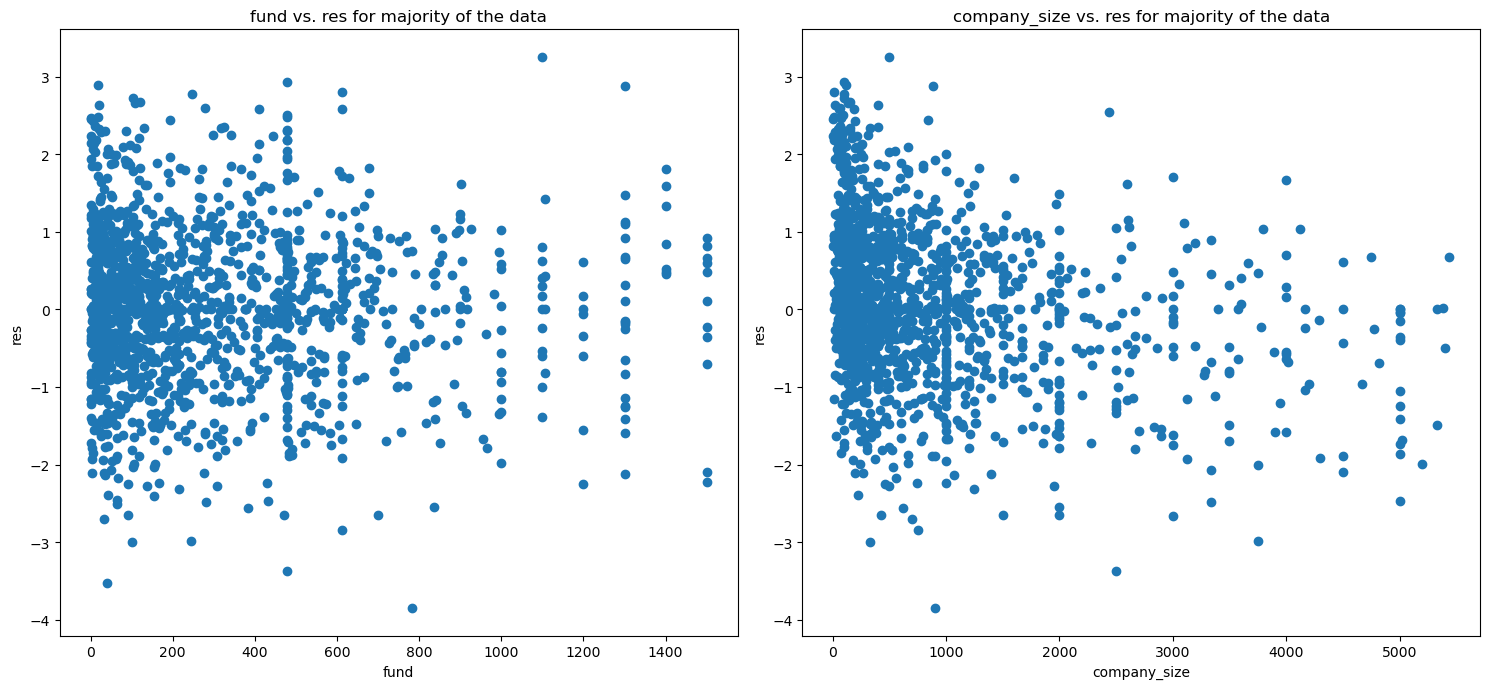

In [40]:
copy = all_company.copy()
copy["res"] = res
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
columns = ['fund', 'company_size']

for i, col in enumerate(columns):
    upper_bound = copy[col].quantile(0.90)
    majority_data = copy[(copy[col] >= 0) & (copy[col] <= upper_bound)]
    # Plot the scatter plot in the corresponding subplot
    axs[i].scatter(majority_data[col], majority_data['res'])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('res')
    axs[i].set_title(f'{col} vs. res for majority of the data')

plt.tight_layout()
plt.show()

**Conclusion: For checking linearity, we plot the residuals against the independent variable. As we can see for some of the graph the residuals are randomly scattered around 0, then the assumption of linearity is likely satisfied.**

### Multicolinearity 

In [41]:
exog = full_model.model.exog
names = full_model.params.index

for i in range(1, exog.shape[1]):
    vif_value = variance_inflation_factor(exog, i)
    if vif_value <= 5:
        print(f"VIF: {names[i]}: {vif_value}")

VIF: hq_location[T.Chennai]: 4.048791858934004
VIF: hq_location[T.Kolkata]: 2.0246330272982873
VIF: hq_location[T.Nashik]: 2.025700016224847
VIF: hq_location[T.Noida]: 2.04757152662158
VIF: hq_location[T.Pune]: 2.1131565271069275
VIF: industry[T.Aerospace]: 3.0723668091309886
VIF: industry[T.Construction]: 4.158879198389293
VIF: industry[T.Legal]: 3.8021001612136924
VIF: industry[T.Manufacturing]: 2.484912244080309
VIF: stage[T.Post-IPO]: 3.984215057638617
VIF: stage[T.Private Equity]: 1.5095668784545615
VIF: stage[T.Seed]: 1.5093460803459033
VIF: stage[T.Series A]: 2.0866904941561972
VIF: stage[T.Series B]: 2.950941428329474
VIF: stage[T.Series C]: 2.8006385352554304
VIF: stage[T.Series D]: 2.6182527603259445
VIF: stage[T.Series E]: 1.9581206667675812
VIF: stage[T.Series F]: 1.5697040842003809
VIF: stage[T.Series G]: 1.1898802310644345
VIF: stage[T.Series H]: 1.473051931297917
VIF: stage[T.Series I]: 1.1040543702311536
VIF: stage[T.Series J]: 1.140334773999578
VIF: stage[T.Subsidiary]

#### Drop the covariate(s) with a variance inflation factor greater than 5 and fit the linear regression model again.


In [42]:
without_formula = "laid_off_percent ~ " + "hq_location + industry + stage + fund + company_size + year + month"
model_multi_adjusted = smf.ols(without_formula, data = all_company).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:       laid_off_percent   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     3.111
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           5.33e-36
Time:                        17:00:40   Log-Likelihood:                -1776.9
No. Observations:                1659   AIC:                             3978.
Df Residuals:                    1447   BIC:                             5126.
Df Model:                         211                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

## Mixed selection for feature selection

In [43]:
import statsmodels.formula.api as smf
import numpy as np

def forward(df, criterion, response='y'):
    selected_columns = set()
    columns = set(df.columns.drop(response))
    best_criterion = np.inf
    while len(selected_columns) < len(columns):
        potential_columns, current_criterion = add(df, selected_columns, columns, criterion, response)
        if current_criterion > best_criterion:
            break
        else:
            selected_columns = potential_columns
            best_criterion = current_criterion
            print(f'Criterion: {best_criterion}')
    return selected_columns

def backward(df, criterion, response='y'):
    selected_columns = set(df.columns.drop(response))
    best_criterion = np.inf
    while len(selected_columns) > 0:
        potential_column, current_criterion = remove(df, selected_columns, criterion, response)
        if current_criterion > best_criterion:
            break
        else:
            selected_columns = selected_columns - {potential_column}
            best_criterion = current_criterion
            print(f'Criterion: {best_criterion}')
    return selected_columns

def add(df, selected_columns, columns, criterion, response='y'):
    best_criterion = np.inf
    best_column = None
    for column in columns - selected_columns:
        new_columns = selected_columns.union({column})
        formula = f'{response} ~ {" + ".join(new_columns)}'
        try:
            current_criterion = criterion(formula, df)
            if current_criterion < best_criterion:
                best_criterion = current_criterion
                best_column = column
        except Exception as e:
            print(f"Error with formula: {formula}, error: {e}")
    return selected_columns.union({best_column}), best_criterion

def remove(df, selected_columns, criterion, response='y'):
    worst_criterion = np.inf
    worst_column = None
    for column in selected_columns:
        new_columns = selected_columns - {column}
        if not new_columns:  # Ensure there's always at least one predictor
            continue
        formula = f'{response} ~ {" + ".join(new_columns)}'
        try:
            current_criterion = criterion(formula, df)
            if current_criterion < worst_criterion:
                worst_criterion = current_criterion
                worst_column = column
        except Exception as e:
            print(f"Error with formula: {formula}, error: {e}")
    return worst_column, worst_criterion

bic_criterion = lambda formula, df: smf.ols(formula, data=df).fit().bic

response = 'laid_off_percent'
variables = all_company.columns.drop(response)
f_vars = forward(all_company, bic_criterion, response=response)
b_vars = backward(all_company, bic_criterion, response=response)
vars = f_vars.union(b_vars)
print("variables: " + str(vars))

if vars:  # Ensure vars is not empty
    forward_formula = f'{response} ~ {"+".join(vars)}'
    forward_fit = smf.ols(forward_formula, data=all_company).fit()
    print(forward_fit.summary())
else:
    print("No variables selected.")


Criterion: 3990.175213825452
Criterion: 3979.42659924631
Criterion: 3970.570501241738
Criterion: 3968.885269532625
Criterion: 4370.4511803242685
Criterion: 4093.873581303478
Criterion: 3975.012665185608
Criterion: 3968.8852695326245
variables: {'fund', 'stage', 'year', 'company_size'}
                            OLS Regression Results                            
Dep. Variable:       laid_off_percent   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     21.16
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           3.82e-62
Time:                        17:00:44   Log-Likelihood:                -1914.0
No. Observations:                1659   AIC:                             3866.
Df Residuals:                    1640   BIC:                             3969.
Df Model:                          18                                         
Cov

## Used Lasso for feature selection

In [44]:
#perform one-hot encoding for categorical data
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform the data
encoded_data = encoder.fit_transform(all_company[['hq_location', 'industry', 'stage', 'country']])

# Get feature names after one-hot encoding
encoded_feature_names = encoder.get_feature_names_out(['hq_location', 'industry', 'stage', 'country'])

# Create a DataFrame with the encoded variables
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names)

# Drop the original columns from the cleaned dataframe and add the new one-hot encoded columns
temp = all_company.drop(columns=['hq_location', 'industry', 'stage', 'country'])
one_hot = pd.concat([temp.reset_index(), encoded_df], axis=1)

In [45]:
all_company

hq_location        industry  laid_off_percent     stage         country  \
3566  Los Angeles          Retail         -0.916291  Series C   United States   
3565  SF Bay Area        Consumer         -0.287682      Seed   United States   
3564  Los Angeles  Transportation         -2.302585   Unknown   United States   
3561       Denver          Travel         -1.514128  Series C   United States   
3562       Austin         Support          0.000000      Seed   United States   
...           ...             ...               ...       ...             ...   
0       New Delhi          Retail         -1.897120   Unknown           India   
8           Ghent       Marketing         -2.302585  Series D         Belgium   
4          Prague          Retail         -1.832581  Acquired  Czech Republic   
3     SF Bay Area      Healthcare         -1.609438  Series E   United States   
0          Denver       Aerospace         -1.386294  Series B   United States   

             fund  company_size  year  month  
3566    90.000000          50.0  2020      3  
3565     1.000000           8.0  2020      3  
3564    45.000000          80.0  2020      3  
3561    79.000000         591.0  2020      3  
3562     6.000000          16.0  2020      3  
...           ...           ...   ...    ...  
0      180.000000        1000.0  2024      4  
8      159.000000         500.0  2024      4  
4      611.811494         625.0  2024      4  
3     1400.000000         500.0  2024      4  
0      158.000000         120.0  2024      4  

[1659 rows x 9 columns]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(one_hot.drop(columns = ["laid_off_percent"]),one_hot["laid_off_percent"], test_size=0.2, random_state=42)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

alpha = 0.08
lasso = Lasso(alpha=alpha)
lasso.fit(train_scaled, y_train)

coef_abs = np.abs(lasso.coef_)

feature_names = one_hot.drop(columns = "laid_off_percent").columns

selected_features = feature_names[coef_abs > 0]

print("Selected features:", selected_features)

Selected features: Index(['fund', 'company_size', 'year', 'industry_Hardware', 'stage_Post-IPO',
       'stage_Private Equity', 'stage_Seed', 'stage_Series A',
       'stage_Series B'],
      dtype='object')


The lasso result is align with the mix selection result
> After feature selection: year, stage, fund, company size would be best predictor for laid off rate

In [47]:
# fit model with selected features
selected_formula = "laid_off_percent ~ " + "+".join([i for i in vars])

## Cross-validation for model evaluation

In [48]:
print(f'full model formula: {formula}')
print(f'hypothsized model formula: {hypothsis_formula}')
print(f'without multicolineary formula: {without_formula}')
print(f'selected formula: {selected_formula}')

full model formula: laid_off_percent ~ hq_location + industry + stage + country + fund + company_size + year + month
hypothsized model formula: laid_off_percent ~ hq_location + industry + stage + fund + company_size + year
without multicolineary formula: laid_off_percent ~ hq_location + industry + stage + fund + company_size + year + month
selected formula: laid_off_percent ~ fund+stage+year+company_size


#### Since some head_quarter only appear one time in the data so we need make sure to include them in the training data 

In [49]:
hq_counts = all_company['hq_location'].value_counts()
#get hq appear only once in the dataset
unique_hq = hq_counts[hq_counts == 1].index

unique_hq_rows = all_company[all_company['hq_location'].isin(unique_hq)]
remaining_data = all_company[~all_company['hq_location'].isin(unique_hq)]

temp_train, test = train_test_split(remaining_data, test_size=0.25, random_state = 200)

# Combine unique headquarters rows with the train set
train = pd.concat([temp_train, unique_hq_rows])

In [50]:
def cv_error(formula, train, test):
    model = smf.ols(formula, data=train).fit()
    yhat_test = model.predict(test)
    error = np.sum((test['laid_off_percent'] - yhat_test) ** 2)
    return error
print(f'Full model: {cv_error(formula, train, test)}')
print(f'hypothsized model: {cv_error(hypothsis_formula, train, test)}')
print(f'without multicolineary model: {cv_error(without_formula, train, test)}')
print(f'selected model: {cv_error(selected_formula, train, test)}')

Full model: 269.16650669117325
hypothsized model: 260.3379607646537
without multicolineary model: 260.1827787322273
selected model: 248.09572349277946


**Conclusion:**

Based on the cross-validation results, we can conclude that the stage of the company is the most important indicator for the laid-off rate in this dataset. To further investigate this relationship, we will leverage additional information from another dataset focusing on the stock prices in the tech industry.

# Predictive model: Decision Tree
> We choose to use Decision Tree since majority of the featrues we have are categorical

In [51]:
#binned the response variable since laid off rate is continuous
all_company = pd.read_csv("merged.csv").drop(columns = ["company", "date"])
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
all_company['laid_off_bins'] = np.digitize(all_company['laid_off_percent'], bins)
all_company = all_company.drop(columns = "laid_off_percent")
all_company.loc[all_company["laid_off_bins"] == 1, "laid_off_bins"] = "(0,0.2]"
all_company.loc[all_company["laid_off_bins"] == 2, "laid_off_bins"] = "(0.2,0.4]"
all_company.loc[all_company["laid_off_bins"] == 3, "laid_off_bins"] = "(0.4,0.6]"
all_company.loc[all_company["laid_off_bins"] == 4, "laid_off_bins"] = "(0.6,0.8]"
all_company.loc[all_company["laid_off_bins"] == 5, "laid_off_bins"] = "(0.8,1]"
all_company.loc[all_company["laid_off_bins"] == 6, "laid_off_bins"] = "(0.8,1]"
all_company.head()

hq_location        industry     stage        country  fund  company_size  \
0  Los Angeles          Retail  Series C  United States  90.0          50.0   
1  SF Bay Area        Consumer      Seed  United States   1.0           8.0   
2  Los Angeles  Transportation   Unknown  United States  45.0          80.0   
3       Denver          Travel  Series C  United States  79.0         591.0   
4       Austin         Support      Seed  United States   6.0          16.0   

   year  month laid_off_bins  
0  2020      3     (0.4,0.6]  
1  2020      3     (0.6,0.8]  
2  2020      3       (0,0.2]  
3  2020      3     (0.2,0.4]  
4  2020      3       (0.8,1]

### Model fitting + Grid search for hyperparameter tunning
> also take care off the single appearance hq with doing test split, make sure they are trained


In [52]:
X = all_company.drop(columns= "laid_off_bins")
y = all_company['laid_off_bins']
hq_counts = all_company['hq_location'].value_counts()
unique_hq = hq_counts[hq_counts == 1].index
unique_hq_rows = all_company[all_company['hq_location'].isin(unique_hq)]
remaining_data = all_company[~all_company['hq_location'].isin(unique_hq)]
temp_train, test = train_test_split(remaining_data, test_size=0.25, random_state = 200)
train = pd.concat([temp_train, unique_hq_rows])

X_train = train.drop(columns = "laid_off_bins")
y_train = train["laid_off_bins"]
X_test = test.drop(columns = "laid_off_bins")
y_test = test["laid_off_bins"]


encoder = OneHotEncoder(sparse=False, drop='first')
columns_to_encode = ['hq_location', 'industry', 'stage', 'country']
# Fit and transform the training data
X_train_encoded = encoder.fit_transform(X_train[columns_to_encode])
encoded_feature_names = encoder.get_feature_names_out(columns_to_encode)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names)
X_train_encoded_df["month"] = X_train["month"].values
X_train_encoded_df["year"] = X_train["year"].values
X_train_encoded_df["fund"] = X_train["fund"].values
X_train_encoded_df["company_size"] = X_train["company_size"].values

X_test_encoded = encoder.transform(X_test[columns_to_encode])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names)
X_test_encoded_df["month"] = X_test["month"].values
X_test_encoded_df["year"] = X_test["year"].values
X_test_encoded_df["fund"] = X_test["fund"].values
X_test_encoded_df["company_size"] = X_test["company_size"].values



param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6]
}

clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_encoded_df, y_train)

best_clf = grid_search.best_estimator_

print("Best Hyperparameters:")
print(grid_search.best_params_)

y_pred = best_clf.predict(X_test_encoded_df)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters:
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.6203473945409429
F1 Score: 0.5648627585976085


**The performance is not good probability becuase** 
1. the inbalance data as shown in the eda part
> In such caseexploring additional data sourcess, the classifier may struggle to accurately predict the minority class due to its limited representation in the training data
2. not enough features
> the model is too general given limited features and thus, cannot adapt to the complex pattern

If we have more time, we can address this by exploring additional data sources to add more features for better model building